<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Negation_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant', 'MAMS']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def create_quad_plot(data_df: pd.DataFrame) -> List[List[plt.Axes]]:
  fig, axes = plt.subplots(2,2,figsize=(15,10))
  dataset_list_order = [['Restaurant', 'MAMS'],['Laptop', 'mpqa']]
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for row_index, dataset_name_list in enumerate(dataset_list_order):
    for col_index, dataset_name in enumerate(dataset_name_list):
      df = data_df[data_df['Dataset']==dataset_name]
      axes[row_index][col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd',
                                                y='Score', hue='Model',
                                                x='Metric', data=df,
                                                hue_order=HUE_ORDER,
                                                order=METRIC_ORDER,
                                                ax=axes[row_index][col_index])
      axes[row_index][col_index].set_title(f'{dataset_name}')
      if row_index == 0:
        axes[row_index][col_index].set_xlabel('')
      if col_index == 1:
        axes[row_index][col_index].set_ylabel('')
      if row_index != 0 or col_index == 1:
        axes[row_index][col_index].get_legend().remove()
      else:
        axes[row_index][col_index].legend(ncol=7, borderaxespad=0.,
                                          bbox_to_anchor=(0.18, 1.1), 
                                          loc='lower left')
  return axes

def create_triple_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,3,figsize=(22.5, 5))
  dataset_list_order = ['Restaurant', 'MAMS', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.9, 1.1), loc='lower left')
  return axes

def get_negated_data(filtered: bool) -> Dict:
  negation_results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['Restaurant', 'Laptop', 'MAMS']
  split_names = ['Validation', 'Test']

  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    for dataset_name in dataset_names:
      for split_name in split_names:
        if split_name == 'Test':
          result_url = model_url + f'/{dataset_name.lower()}/test_neg.conll'
          if filtered:
            result_url = model_url + f'/{dataset_name.lower()}/test_neg_only.conll'
          if dataset_name == 'MAMS':
            result_url = model_url + f'/{dataset_name}/test_neg.conll'
            if filtered:
              result_url = model_url + f'/{dataset_name}/test_neg_only.conll'
        elif split_name == 'Validation':
          result_url = model_url + f'/{dataset_name.lower()}/dev_neg.conll'
          if filtered:
            result_url = model_url + f'/{dataset_name.lower()}/dev_neg_only.conll'
          if dataset_name == 'MAMS':
            result_url = model_url + f'/{dataset_name}/dev_neg.conll'
            if filtered:
              result_url = model_url + f'/{dataset_name}/dev_neg_only.conll'
        else:
          raise ValueError(f'Can only be Test or Validation split and not {split_name}')
        
        for run_number in range(5):
          with tempfile.TemporaryDirectory() as temp_dir:
            temp_fp = Path(temp_dir, 'temp_file.txt')
            with temp_fp.open('w') as temp_file:
              temp_file.write(requests.get(result_url).text)
            f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=True)
            f1_a_recall, f1_a_precision, f1_a = f1_a
            f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False)
            f1_i_recall, f1_i_precision, f1_i = f1_i
            f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='POS')
            f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
            f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='NEU')
            f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
            f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='NEG') 
            f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
            f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                        metric_func=f1_score, 
                                                        average='macro')
            acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                        metric_func=accuracy_score)
            negation_results_df_dict['Model'].append(model_name)
            negation_results_df_dict['Dataset'].append(dataset_name)
            negation_results_df_dict['Run'].append(run_number)
            negation_results_df_dict['Split'].append(split_name)
            negation_results_df_dict['F1-a'].append(f1_a)
            negation_results_df_dict['F1-a-R'].append(f1_a_recall)
            negation_results_df_dict['F1-a-P'].append(f1_a_precision)
            negation_results_df_dict['F1-i'].append(f1_i)
            negation_results_df_dict['F1-i-R'].append(f1_i_recall)
            negation_results_df_dict['F1-i-P'].append(f1_i_precision)
            negation_results_df_dict['F1-i-pos'].append(f1_i_pos)
            negation_results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
            negation_results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
            negation_results_df_dict['F1-i-neg'].append(f1_i_neg)
            negation_results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
            negation_results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
            negation_results_df_dict['F1-i-neu'].append(f1_i_neu)
            negation_results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
            negation_results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
            negation_results_df_dict['F1-s'].append(f1_s)
            negation_results_df_dict['Acc-s'].append(acc_s)
  return negation_results_df_dict


# Evaluating for negation

In this notebook we evaluate the different Targetted Sentiment Analysis (TSA) models. For more information about the models and the data see the [evaluation notebook for the main data.](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Evaluation_Metrics.ipynb) In this notebook unlike the main data one we are only evaluating on the negated version of the **Laptop** and **Restaurant** datasets.

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

The negation results are in two halves. The first is on the negated version of the datasets that still contain samples that have no negation but overall the number of samples that contain negation is much larger than the original, in this notebook the data will be called **Non-Filtered Negation**. The second half only uses samples that have negation all the other samples are filtered out, in this notebook the data will be called **Filtered Negation**.

## Evaluation on the Non-Filtered Negation data

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Split
5. Metric
6. Score


In [5]:
negation_results_df = pd.DataFrame(get_negated_data(False))
not_metric_cols = ['Model', 'Dataset', 'Run', 'Split']
metric_cols = [col_name for col_name in negation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
negation_results_df = pd.melt(negation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
negation_results_df.head()

,Model,Dataset,Run,Split,Metric,Score
0,STL,Restaurant,0,Validation,F1-a,0.786925
1,STL,Restaurant,1,Validation,F1-a,0.780906
2,STL,Restaurant,2,Validation,F1-a,0.780193
3,STL,Restaurant,3,Validation,F1-a,0.786683
4,STL,Restaurant,4,Validation,F1-a,0.779252


### F1-i

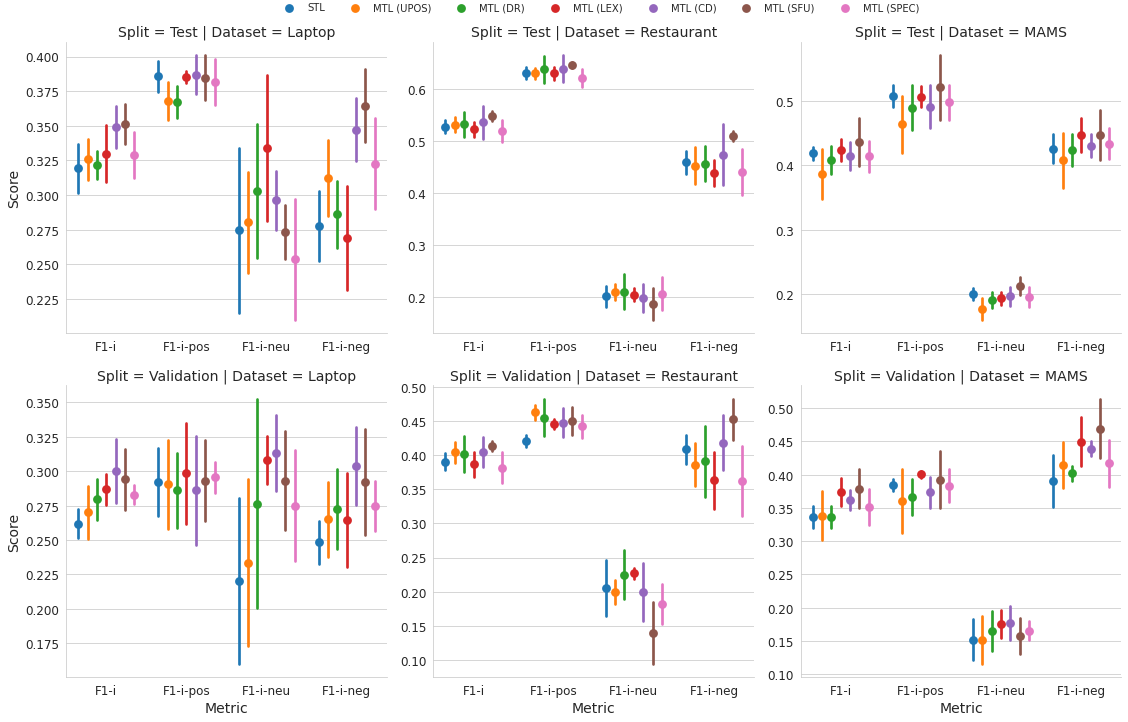

In [22]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = negation_results_df[negation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

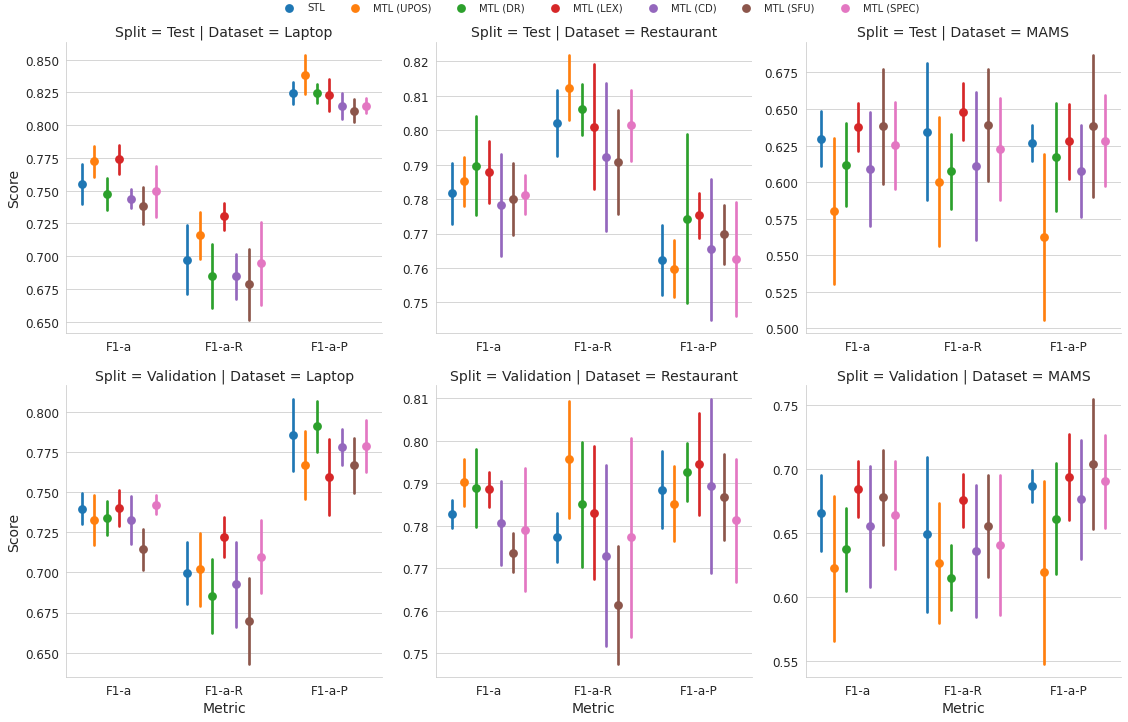

In [23]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = negation_results_df[negation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

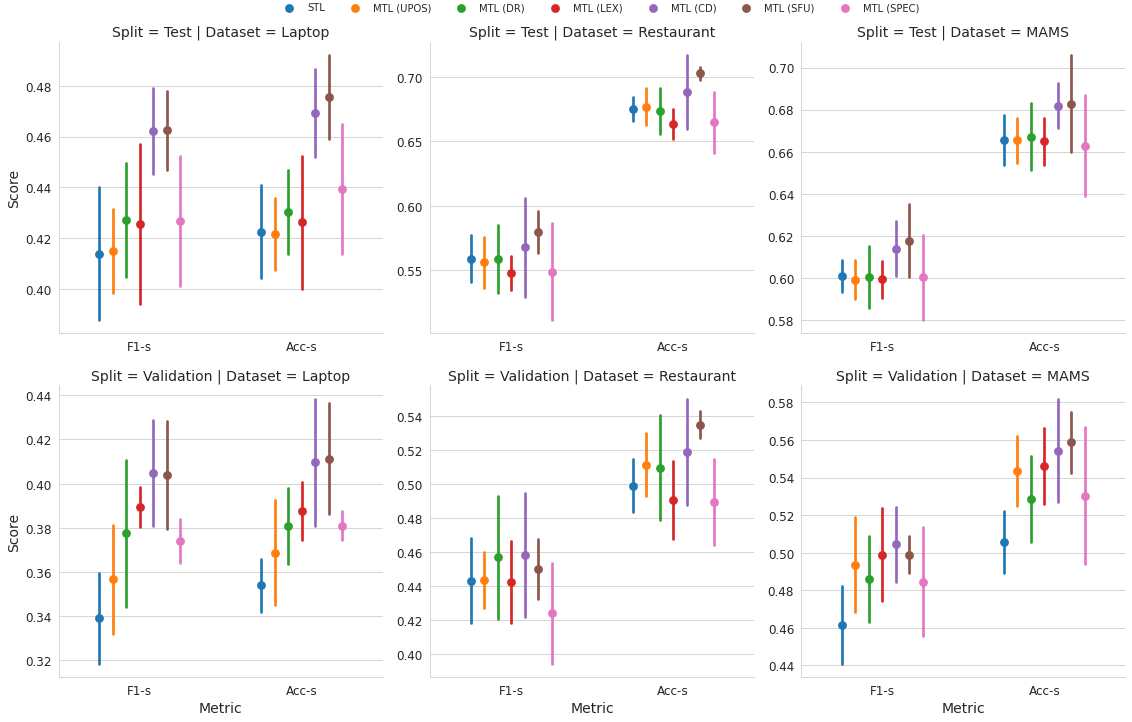

In [25]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = negation_results_df[negation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

To fit the graphs within the paper we also construct them individually for the test and validation results:

#### Validation Results

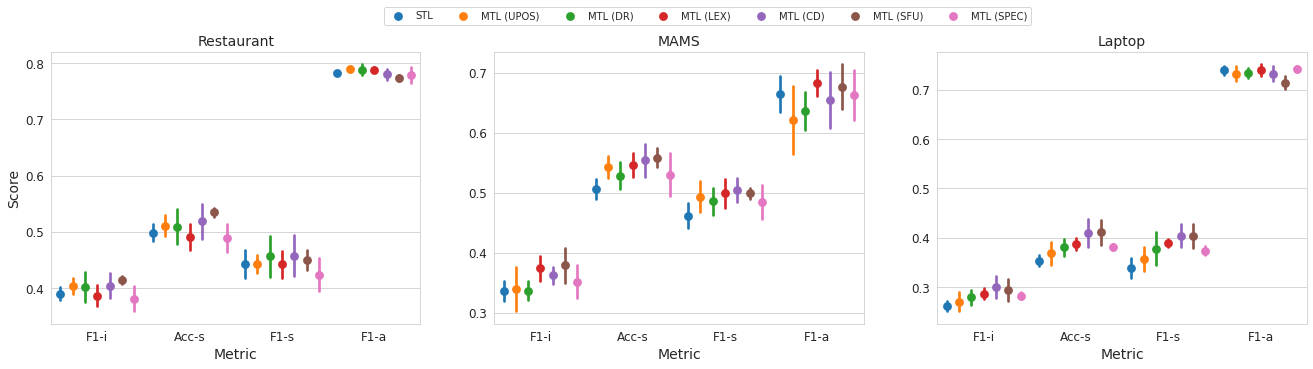

In [27]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = negation_results_df[negation_results_df['Metric'].isin(headline_metric_order)]
validation_headline_results = headline_results[headline_results['Split']=='Validation']
_ = create_triple_plot(validation_headline_results)

#### Test Results:

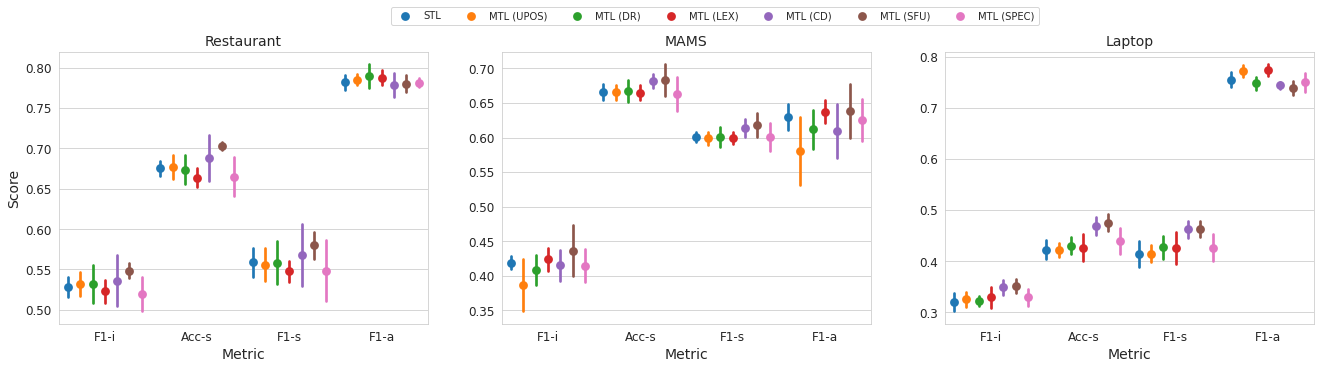

In [28]:
test_headline_results = headline_results[headline_results['Split']=='Test']
_ = create_triple_plot(test_headline_results)

## Evaluation on the Filtered Negation data

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Split
5. Metric
6. Score

In [30]:
negation_results_df = pd.DataFrame(get_negated_data(True))
not_metric_cols = ['Model', 'Dataset', 'Run', 'Split']
metric_cols = [col_name for col_name in negation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
negation_results_df = pd.melt(negation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
negation_results_df.head()

,Model,Dataset,Run,Split,Metric,Score
0,STL,Restaurant,0,Validation,F1-a,0.814815
1,STL,Restaurant,1,Validation,F1-a,0.814126
2,STL,Restaurant,2,Validation,F1-a,0.817680
3,STL,Restaurant,3,Validation,F1-a,0.812616
4,STL,Restaurant,4,Validation,F1-a,0.806569


### F1-i

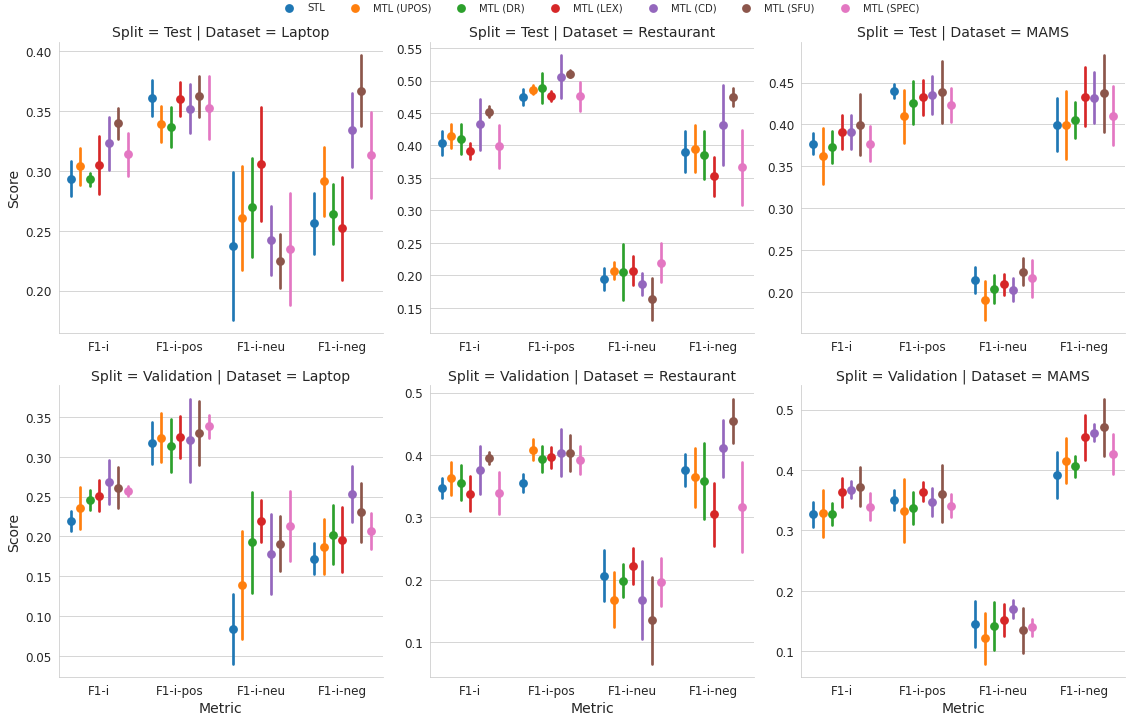

In [31]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = negation_results_df[negation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

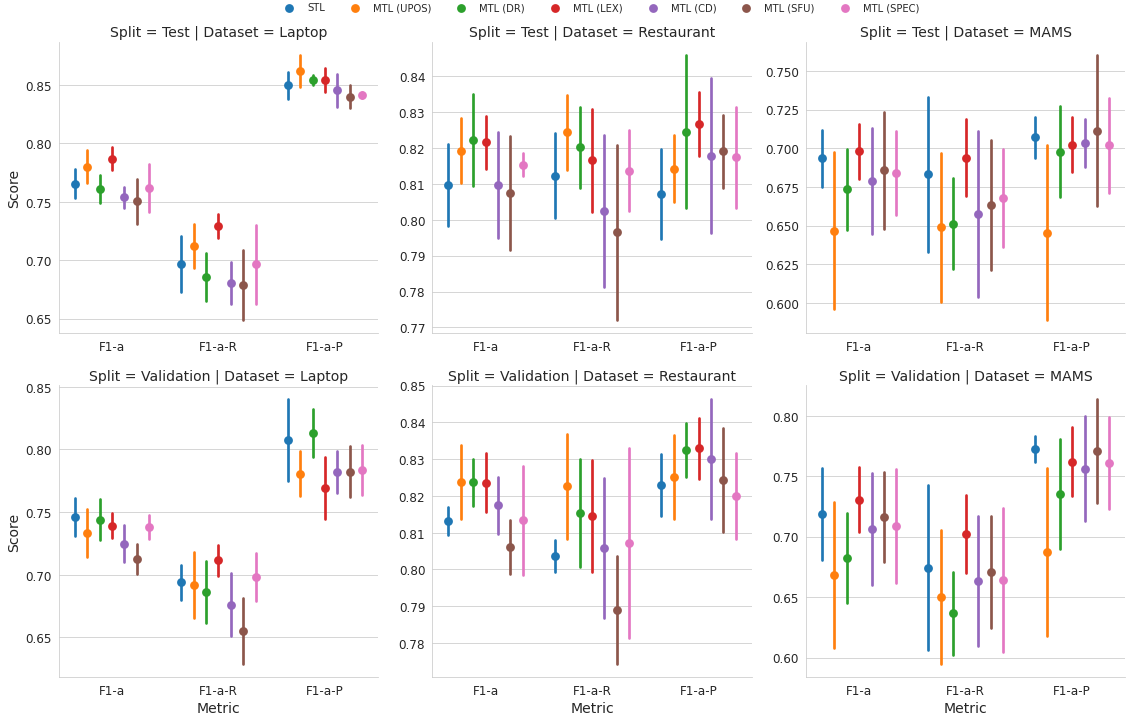

In [32]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = negation_results_df[negation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

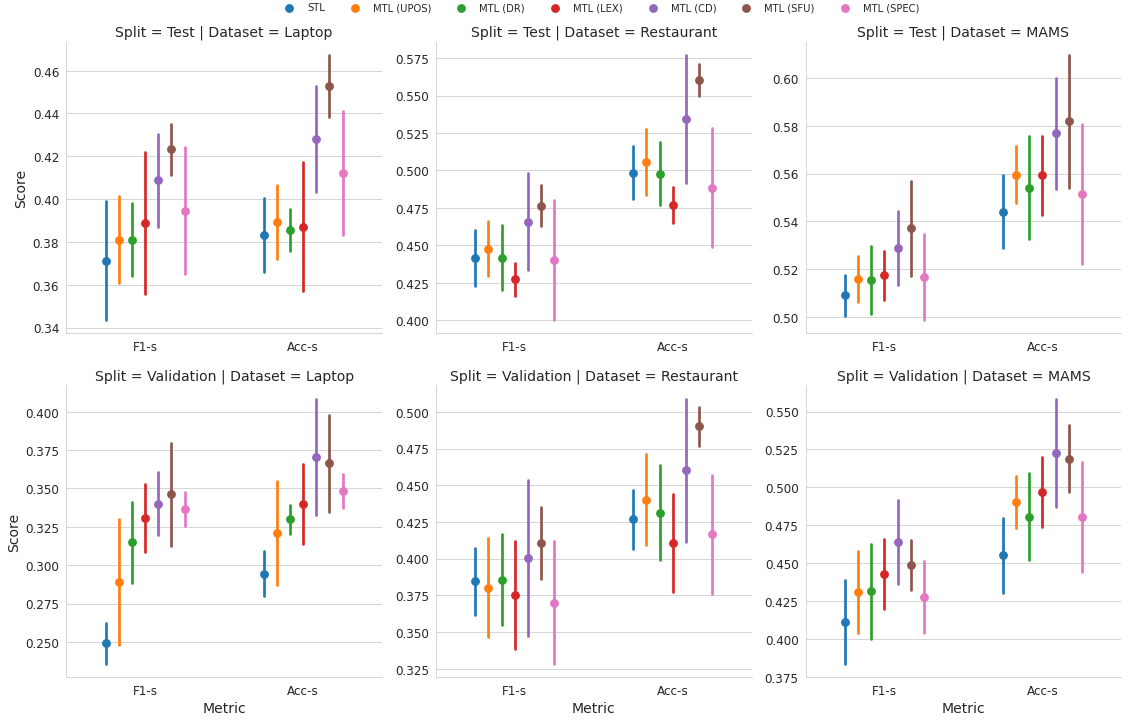

In [33]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = negation_results_df[negation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

To fit the graphs within the paper we also construct them individually for the test and validation results:

#### Validation Results

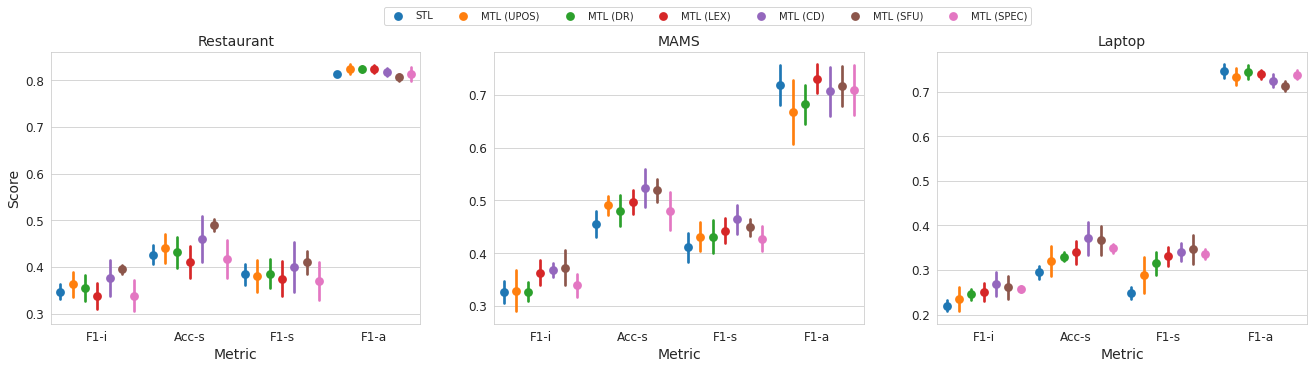

In [34]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = negation_results_df[negation_results_df['Metric'].isin(headline_metric_order)]
validation_headline_results = headline_results[headline_results['Split']=='Validation']
_ = create_triple_plot(validation_headline_results)

#### Test Results

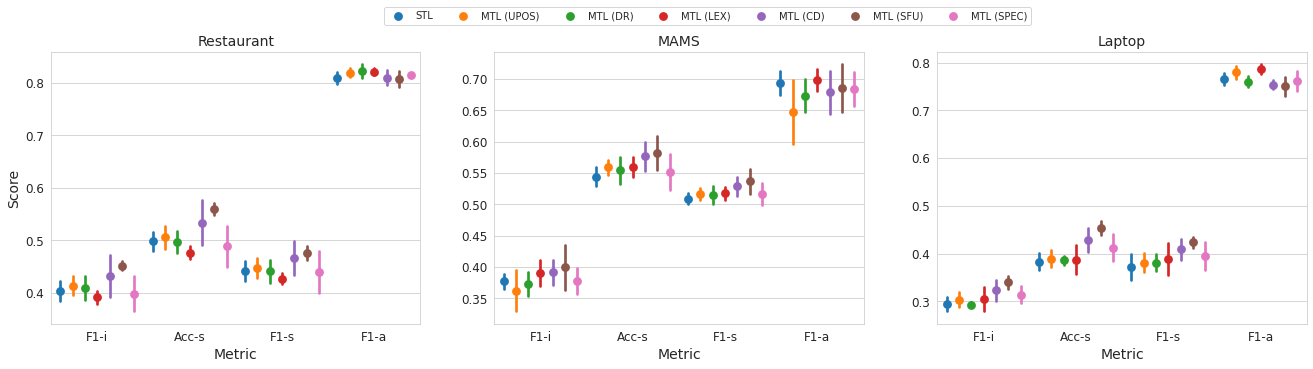

In [35]:
test_headline_results = headline_results[headline_results['Split']=='Test']
_ = create_triple_plot(test_headline_results)